# Airbnb Renting Scene in Seattle
***
### Business Understanding 
In this project,the Seattle Airbnb open dataset 2016-2017 from Kaggle is used to discover a few key aspects of the Airbnb renting scene in Seattle.
The information can be used to help potential hosts assess the price they can charge based on the facilities they 
provide.

A few questions this project seeks to understand are: 
1. What's the sentiment around the guest reviews?
2. Do superhosts have better and more positive reviews?
3. What neighbouthoods have more positive and less positive reviews?
4. What are the key features which determine listing prices?

***
## PART 1: Data exploration and preparation
###There are 3 files in the dataset: 
   
1.**listing.csv**: provides information about hosts, price, room types, property types, listing summary, 
number of reviews etc. about 3818 Airbnb listings in Seattle.
    -There are 4 columns with more than 50% missing data.
    -Columns with the most missing data are: license, square feet, monthly_price, security deposit.
    -There are 2751 hosts in the data and 28% of them are superhosts

2.**calendar.csv**: provides information about occupancy and availability for 3818 listing everyday from 
January 2016 - January 2017
    -There are 4 columns in the calendar dataset: listing ID, Date, Availability (t: available, f: occupied), Price
    -If the listing is occupied, there will be price for that listing for that date. Therefore, price is the
only column with N/A value in this dataset

3.**reviews.csv**: provides 84849 reviews for each property from 2009
    
### The data doesn't seem to be clean with some numeric fields having characters which need to be cleaned before we can proceed with modelling

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

#import packages for price prediction
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestRegressor 

In [180]:
calendar = pd.read_csv('./seattle/calendar.csv')
calendar.head()

nRow, nCol = calendar.shape
print(f'There are {nRow} rows and {nCol} columns in calendar.')
print(len(calendar['listing_id'].unique()))
print(max(calendar['date']))
print(min(calendar['date']))

There are 1393570 rows and 4 columns in calendar.
3818
2017-01-02
2016-01-04


In [181]:
calendar.isna().describe()

,listing_id,date,available,price
count,1393570,1393570,1393570,1393570
unique,1,1,1,2
top,False,False,False,False
freq,1393570,1393570,1393570,934542


In [182]:
listings = pd.read_csv('./seattle/listings.csv')
reviews=pd.read_csv('./seattle/reviews.csv')

In [313]:
summary_listings=listings.isna().describe().T
summary_listings['%_nulls']=summary_listings['freq']/summary_listings['count']*100
summary_listings[summary_listings['top']==True].sort_values(by='%_nulls',ascending=False)

,count,unique,top,freq,%_nulls
license,3818,1,True,3818,100
square_feet,3818,2,True,3721,97.4594
monthly_price,3818,2,True,2301,60.2672
security_deposit,3818,2,True,1952,51.1262


In [314]:
null_listings = [i for i in listings.columns if listings[i].isnull().any()]
print(null_listings)
print('Number of columns with missing data:',len(nan_cols_listings))

['summary', 'space', 'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'xl_picture_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'zipcode', 'property_type', 'bathrooms', 'bedrooms', 'beds', 'square_feet', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'license', 'reviews_per_month']
Number of columns with missing data: 45


In [315]:
#number of unique hosts
unique_host = listings['host_id'].unique()
print('Number of unique hosts in listing dataset:', len(unique_host))
print('Percentage of them are superhosts:',listings['host_is_superhost'][listings['host_is_superhost']=='t'].count()/len(listings['host_id'].unique()))

Number of unique hosts in listing dataset: 2751
Percentage of them are superhosts: 0.28280625227190115


In [316]:
nRow, nCol = reviews.shape
print(f'There are {nRow} rows and {nCol} columns in reviews.')
nRow, nCol = listings.shape
print(f'There are {nRow} rows and {nCol} columns in listings.')

There are 84849 rows and 6 columns in reviews.
There are 3818 rows and 93 columns in listings.


In [319]:
#number of reviewes per listing
print('Number of reviewes per listing')
reviews.groupby('listing_id').count().sort_values(by=['id'],ascending=False)


Number of reviewes per listing


,id,date,reviewer_id,reviewer_name,comments
listing_id,,,,,
208356,474,474,474,474,474
365550,466,466,466,466,466
25002,404,404,404,404,404
47196,353,353,353,353,353
63308,320,320,320,320,320
...,...,...,...,...,...
6292452,1,1,1,1,1
6305798,1,1,1,1,1
8080939,1,1,1,1,1


Number of room types


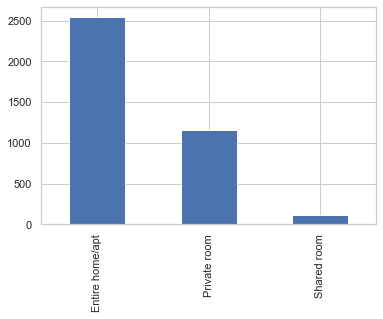

In [321]:
print('Number of room types')
listings['room_type'].value_counts().plot(kind='bar')

In [322]:
print('Number of room types by neighbourhood')
listings.groupby(['room_type','neighbourhood'])['id'].count()

Number of room types by neighbourhood


room_type        neighbourhood            
Entire home/apt  Alki                          19
                 Arbor Heights                  2
                 Atlantic                      34
                 Ballard                      138
                 Belltown                     192
                 Bitter Lake                    4
                 Brighton                       3
                 Broadview                     10
                 Broadway                       4
                 Bryant                        20
                 Capitol Hill                 245
                 Cedar Park                     5
                 Central Business District     75
                 Columbia City                 39
                 Crown Hill                     8
                 Dunlap                         4
                 Eastlake                      30
                 Fairmount Park                 1
                 Fauntleroy                     6
       

In [323]:
#number of unique hosts
unique_host = listings['host_id'].unique()
'Number of unique hosts in listing dataset:', len(unique_host)

('Number of unique hosts in listing dataset:', 2751)

***
## PART 2: Price Prediction (Regression - Supervised Learning)
Our focus will be predicting the price of the property based on the attributes from the listing dataset.
45 variables in this listing dataset have missing values, 
the first 20 variables with majority of missing values will be dropped from the analysis. 
In this analysis, only 10 variables will be used for prediction: 5 continous variables, 15 categorical variables

### 3. Data Preparation for Price Prediction

- **Step 1 - Clean dependent variable - price**:  
    A correlation matrix between continuous variables in X shows that beds and accommodates are 
    highly correlated to each other so beds is dropped out of the predictor variables. 
- **Step 2 - Split data for training and test set**:  
    Split train and test set using StratifiedShuffleSplit to reserve the proportion of listing by 
    location as location is likely to have influence on price 
- **Step 3 - Prepare the Datasets
(Dealing with missing values + scale continuous variables + One Hot Encoding categorical data)**: 


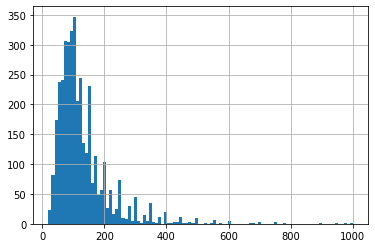

In [188]:
listings['cleaned_price'] = listings['price'].str.replace("$","").str.replace("'","").str.replace(",","").astype('float')
listings["cleaned_price"].hist(bins=100);

In [189]:
set(listings.columns) - set(null_listings[:20])

{'accommodates',
 'amenities',
 'availability_30',
 'availability_365',
 'availability_60',
 'availability_90',
 'bathrooms',
 'bed_type',
 'bedrooms',
 'beds',
 'calculated_host_listings_count',
 'calendar_last_scraped',
 'calendar_updated',
 'cancellation_policy',
 'city',
 'cleaned_price',
 'cleaning_fee',
 'country',
 'country_code',
 'description',
 'experiences_offered',
 'extra_people',
 'first_review',
 'guests_included',
 'has_availability',
 'host_has_profile_pic',
 'host_id',
 'host_identity_verified',
 'host_total_listings_count',
 'host_url',
 'host_verifications',
 'id',
 'instant_bookable',
 'is_location_exact',
 'jurisdiction_names',
 'last_review',
 'last_scraped',
 'latitude',
 'license',
 'listing_url',
 'longitude',
 'market',
 'maximum_nights',
 'minimum_nights',
 'monthly_price',
 'name',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'number_of_reviews',
 'picture_url',
 'price',
 'property_type',
 'require_guest_phone_verification

In [190]:
subset=subset.dropna()

In [191]:
subset['extra_people'] = listings['price'].str.replace("$","").str.replace("'","").str.replace(",","").astype('float')
subset[subset['zipcode']=='99\n98122']='9822'

/Users/vbardarova/Desktop/beat-poc-utilities/test/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [192]:
subset['zipcode']=subset['zipcode'].astype('int64')

In [194]:
subset = subset.drop(columns=[
#     'room_type_9822',
#     'host_response_rate_9822',
    'smart_location'
,'room_type'
,'require_guest_profile_picture'
,'require_guest_phone_verification'
# ,'property_type'
,'neighbourhood_group_cleansed'
,'bed_type'
,'cancellation_policy'
,'city'
,'host_has_profile_pic'
,'host_identity_verified'
,'host_is_superhost'
,'host_response_rate'
,'instant_bookable'
,'is_location_exact'
])

In [195]:
subset['zipcode']=subset['zipcode'].astype('int64')

In [198]:
quantitative_variables = ['accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'calculated_host_listings_count',
 'extra_people',
 'host_listings_count',
#  'host_response_rate',
 'host_total_listings_count',
 'maximum_nights',
 'minimum_nights',
 'zipcode',
'cleaned_price']

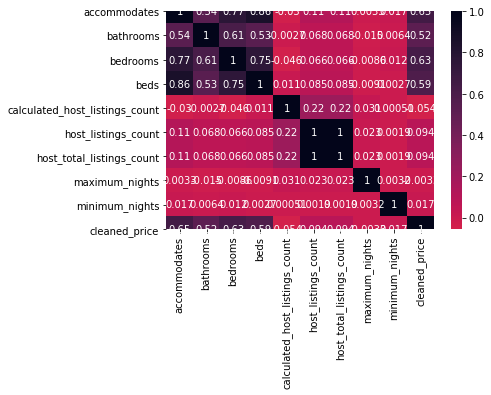

In [199]:
# A correlation matrix between continuous variables and y
corr = listings[quantitative_variables].corr()
cmap = sns.cm.rocket_r
ax = sns.heatmap(corr, annot=True, center = 0, cmap=cmap, linecolor='white')

### Split Training and Test Set

In [201]:
subset_col = ['neighbourhood_group_cleansed',
              'zipcode',
              'room_type',
              'bedrooms',
              'bathrooms',
#               'beds',
              'host_is_superhost',
              'accommodates', 
              'number_of_reviews',
              'calculated_host_listings_count',
                'smart_location',
                'require_guest_profile_picture'
                ,'require_guest_phone_verification'
                ,'bed_type'
                ,'cancellation_policy'
                ,'city'
                ,'host_has_profile_pic'
                ,'host_identity_verified'
                ,'host_response_rate'
                ,'instant_bookable'
                ,'is_location_exact'
                , "cleaned_price"]

subset = listings[subset_col]

In [202]:
# Split train and test set using StratifiedShuffleSplit to keep the proportion of listings by location 
## as location is likely to have an impact on price 

split = StratifiedShuffleSplit(n_splits=1, test_size =0.2, random_state=42)

for train_index, test_index in split.split(subset, subset['neighbourhood_group_cleansed']):
    strat_train_set = subset.loc[train_index]
    strat_test_set = subset.loc[test_index]
    
print('Of the total of {} listings, {} listings in train set, and {} listings in test set'
      .format(len(subset),len(strat_train_set), len(strat_test_set)))

Of the total of 3818 listings, 3054 listings in train set, and 764 listings in test set


In [203]:
#check the proportion of listings by neighborhood group between the original dataset and train/test set after split
subset['neighbourhood_group_cleansed'].value_counts()/len(subset)

Other neighborhoods    0.207962
Capitol Hill           0.148507
Downtown               0.138816
Central Area           0.096647
Queen Anne             0.077266
Ballard                0.060241
West Seattle           0.053169
Rainier Valley         0.041645
University District    0.031954
Beacon Hill            0.030906
Cascade                0.023311
Northgate              0.020953
Delridge               0.020691
Lake City              0.017548
Magnolia               0.015977
Seward Park            0.011524
Interbay               0.002881
Name: neighbourhood_group_cleansed, dtype: float64

In [204]:
strat_test_set['neighbourhood_group_cleansed'].value_counts()/len(strat_test_set)

Other neighborhoods    0.208115
Capitol Hill           0.147906
Downtown               0.138743
Central Area           0.096859
Queen Anne             0.077225
Ballard                0.060209
West Seattle           0.053665
Rainier Valley         0.041885
University District    0.031414
Beacon Hill            0.031414
Cascade                0.023560
Northgate              0.020942
Delridge               0.020942
Lake City              0.017016
Magnolia               0.015707
Seward Park            0.011780
Interbay               0.002618
Name: neighbourhood_group_cleansed, dtype: float64

In [205]:
strat_train_set['neighbourhood_group_cleansed'].value_counts()/len(strat_train_set)

Other neighborhoods    0.207924
Capitol Hill           0.148657
Downtown               0.138834
Central Area           0.096595
Queen Anne             0.077276
Ballard                0.060249
West Seattle           0.053045
Rainier Valley         0.041585
University District    0.032089
Beacon Hill            0.030779
Cascade                0.023248
Northgate              0.020956
Delridge               0.020629
Lake City              0.017682
Magnolia               0.016045
Seward Park            0.011460
Interbay               0.002947
Name: neighbourhood_group_cleansed, dtype: float64

In [289]:
X_train = strat_train_set.drop(['cleaned_price'],axis=1)
y_train = strat_train_set['cleaned_price']

X_test = strat_test_set.drop(['cleaned_price'],axis=1)
y_test = strat_test_set['cleaned_price']

In [207]:
X_train.dtypes

neighbourhood_group_cleansed         object
zipcode                              object
room_type                            object
bedrooms                            float64
bathrooms                           float64
host_is_superhost                    object
accommodates                          int64
number_of_reviews                     int64
calculated_host_listings_count        int64
smart_location                       object
require_guest_profile_picture        object
require_guest_phone_verification     object
bed_type                             object
cancellation_policy                  object
city                                 object
host_has_profile_pic                 object
host_identity_verified               object
host_response_rate                   object
instant_bookable                     object
is_location_exact                    object
dtype: object

In [208]:
continuous_col=['bedrooms', 'bathrooms', 'accommodates', 'number_of_reviews','calculated_host_listings_count']
categorical_col = [col for col in X_train.columns if col not in continuous_col]
continuous_col, categorical_col

(['bedrooms',
  'bathrooms',
  'accommodates',
  'number_of_reviews',
  'calculated_host_listings_count'],
 ['neighbourhood_group_cleansed',
  'zipcode',
  'room_type',
  'host_is_superhost',
  'smart_location',
  'require_guest_profile_picture',
  'require_guest_phone_verification',
  'bed_type',
  'cancellation_policy',
  'city',
  'host_has_profile_pic',
  'host_identity_verified',
  'host_response_rate',
  'instant_bookable',
  'is_location_exact'])

In [209]:
#impute missing values using most_frequent values for categorical variables
# and median for discrete variables ( #bedrooms etc)
imp_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_frequent.fit(X_train[categorical_col])
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_median.fit(X_train[continuous_col])

# scale discrete and continuous variables
scaler = StandardScaler()
scaler.fit(X_train[continuous_col])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [212]:
def preProcess_one_hot_encoder(df):
    """dummify categorical variables
    """
    columns = categorical_col 
    for column in columns:
        df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
    temp1 = df.columns.values

    df = df.drop(columns=columns,axis=1)
    return df

def clean_data(df, categorical_col, continuous_col, imp_frequent, imp_median, scaler):

    """
    Function to clean training and test datasubset including: impute missing values, scale continuous data, 
    and one-hot-encode categorical data

    """

    continuous_X = pd.DataFrame(imp_median.transform(df[continuous_col]),columns = continuous_col)
    
    scaled_X = pd.DataFrame(scaler.transform(continuous_X),columns=continuous_col)

    # Create dummy variables for categorical data
    categorical_X = pd.DataFrame(imp_frequent.transform(df[categorical_col]),columns = categorical_col)
    encoded_X= preProcess_one_hot_encoder(categorical_X)
    encoded_X = pd.get_dummies(categorical_X)
    
    #combined dummy variables and continuous variables into one dataframe
    final_ds = encoded_X
    print(final_ds.shape)
    print(scaled_X.shape)
    final_ds[['bedrooms', 'bathrooms', 'accommodates', 'number_of_reviews','calculated_host_listings_count']] = scaled_X
    
    print('Return dataframe with {} listings and {} columns'.format(final_ds.shape[0],final_ds.shape[1]))
    display(final_ds.head())
    
    return final_ds

In [213]:
cleaned_X_train = clean_data(X_train, categorical_col, continuous_col,imp_frequent, imp_median, scaler)

(3054, 128)
(3054, 5)
Return dataframe with 3054 listings and 133 columns


,neighbourhood_group_cleansed_Ballard,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Magnolia,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Other neighborhoods,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle,zipcode_98101,zipcode_98102,zipcode_98103,zipcode_98104,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98121,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98134,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98177,zipcode_98178,zipcode_98199,zipcode_99\n98122,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,host_is_superhost_f,host_is_superhost_t,"smart_location_Ballard, Seattle, WA","smart_location_Phinney Ridge Seattle, WA","smart_location_Seattle , WA","smart_location_Seattle, WA","smart_location_West Seattle, WA","smart_location_seattle, wa","smart_location_西雅图, WA",require_guest_profile_picture_f,require_guest_profile_picture_t,require_guest_phone_verification_f,require_guest_phone_verification_t,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,"city_Ballard, Seattle",city_Phinney Ridge Seattle,city_Seattle,city_Seattle,city_West Seattle,city_seattle,city_西雅图,host_has_profile_pic_f,host_has_profile_pic_t,host_identity_verified_f,host_identity_verified_t,host_response_rate_100%,host_response_rate_17%,host_response_rate_25%,host_response_rate_30%,host_response_rate_31%,host_response_rate_33%,host_response_rate_38%,host_response_rate_40%,host_response_rate_43%,host_response_rate_50%,host_response_rate_55%,host_response_rate_56%,host_response_rate_57%,host_response_rate_58%,host_response_rate_60%,host_response_rate_63%,host_response_rate_64%,host_response_rate_65%,host_response_rate_67%,host_response_rate_68%,host_response_rate_69%,host_response_rate_70%,host_response_rate_71%,host_response_rate_75%,host_response_rate_76%,host_response_rate_78%,host_response_rate_80%,host_response_rate_81%,host_response_rate_82%,host_response_rate_83%,host_response_rate_86%,host_response_rate_87%,host_response_rate_88%,host_response_rate_89%,host_response_rate_90%,host_response_rate_91%,host_response_rate_92%,host_response_rate_93%,host_response_rate_94%,host_response_rate_95%,host_response_rate_96%,host_response_rate_97%,host_response_rate_98%,host_response_rate_99%,instant_bookable_f,instant_bookable_t,is_location_exact_f,is_location_exact_t,bedrooms,bathrooms,accommodates,number_of_reviews,calculated_host_listings_count
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,-1.490055,-0.444533,-1.197597,-0.590587,0.529217
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.792376,-0.444533,0.332295,-0.403832,-0.332404
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,-0.34884

In [214]:
cleaned_X_test = clean_data(X_test, categorical_col, continuous_col,imp_frequent, imp_median, scaler)

(764, 104)
(764, 5)
Return dataframe with 764 listings and 109 columns


,neighbourhood_group_cleansed_Ballard,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Magnolia,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Other neighborhoods,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle,zipcode_98101,zipcode_98102,zipcode_98103,zipcode_98104,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98121,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98134,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98177,zipcode_98178,zipcode_98199,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,host_is_superhost_f,host_is_superhost_t,"smart_location_Seattle , WA","smart_location_Seattle, WA",require_guest_profile_picture_f,require_guest_profile_picture_t,require_guest_phone_verification_f,require_guest_phone_verification_t,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,city_Seattle,city_Seattle,host_has_profile_pic_t,host_identity_verified_f,host_identity_verified_t,host_response_rate_100%,host_response_rate_17%,host_response_rate_25%,host_response_rate_33%,host_response_rate_40%,host_response_rate_50%,host_response_rate_53%,host_response_rate_60%,host_response_rate_63%,host_response_rate_67%,host_response_rate_70%,host_response_rate_71%,host_response_rate_75%,host_response_rate_76%,host_response_rate_78%,host_response_rate_80%,host_response_rate_82%,host_response_rate_83%,host_response_rate_86%,host_response_rate_87%,host_response_rate_88%,host_response_rate_89%,host_response_rate_90%,host_response_rate_91%,host_response_rate_92%,host_response_rate_93%,host_response_rate_94%,host_response_rate_95%,host_response_rate_96%,host_response_rate_97%,host_response_rate_98%,host_response_rate_99%,instant_bookable_f,instant_bookable_t,is_location_exact_f,is_location_exact_t,bedrooms,bathrooms,accommodates,number_of_reviews,calculated_host_listings_count
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,-0.348840,-0.444533,0.332295,-0.243756,0.529217
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,-1.490055,-0.444533,-0.687633,-0.297115,-0.332404
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1.933591,-0.444533,1.352222,1.330321,-0.160080
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.792376,-0.444533,1.352222,-0.270436,-0.332404
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,-0.348840,-0.444533,-0.177669,0.636660,0.012244


In [215]:
to_drop=set(cleaned_X_train.columns)-set(cleaned_X_test.columns)

In [216]:
cleaned_X_train=cleaned_X_train.drop(columns=to_drop)

In [ ]:
print(set(cleaned_X_train.columns)-set(cleaned_X_test.columns))
print(set(cleaned_X_test.columns)-set(cleaned_X_train.columns))

cleaned_X_test=cleaned_X_test.drop(columns=['host_response_rate_53%'])

In [ ]:
y_train = np.where(y_train > y_train.median(), 0, 1)
y_train = pd.Series(y_train)
y_test = np.where(y_test > y_test.median(), 0, 1)
y_test = pd.Series(y_test)

In [294]:
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV #RandomizedSearchCV #GridSearchCV
#import xgboost as xgb

In [295]:
clf=GradientBoostingClassifier(learning_rate=0.1, max_depth=6, max_features=0.7, min_samples_leaf=11, min_samples_split=10, n_estimators=100, subsample=0.9)

In [296]:
clf.fit(cleaned_X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=6,
                           max_features=0.7, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=11, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.9, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [297]:
def c_mat(st, y_hold, y_pred_hold):
    tn,fp,fn,tp = confusion_matrix(y_hold,y_pred_hold).ravel()
    print(st, ": ", "tn:"+str(tn),"fp:"+str(fp),"fn:"+str(fn),"tp:"+str(tp), "tp/fn: "+str(tp/fn), "fp/tn: "+str(fp/tn), 
          "impact_c: "+ str((tn+fn)/(tn+fp+fn+tp)), "impact_a: "+ str((tn-fn)/(tn+fp+fn+tp)))

In [304]:
from sklearn import metrics
y_pred_train = clf.predict(cleaned_X_train)
y_pred_test = clf.predict(cleaned_X_test)


y_pred_proba_train = clf.predict_proba(cleaned_X_train)[:, 1]
y_pred_proba_test = clf.predict_proba(cleaned_X_test)[:, 1]


print('TRAIN (weighted)')
c_mat("train", y_train, y_pred_train)
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))
print("AUC (weighted)is: " + str(metrics.roc_auc_score(y_train, y_pred_train, average='weighted')))

print('TEST (weighted)')
c_mat("test",y_test, y_pred_test)
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))
print("AUC (weighted)is: " + str(metrics.roc_auc_score(y_test, y_pred_test, average='weighted')))


TRAIN (weighted)
train :  tn:1306 fp:184 fn:171 tp:1393 tp/fn: 8.146198830409357 fp/tn: 0.14088820826952528 impact_c: 0.48362802881466926 impact_a: 0.3716437459070072
[[1306  184]
 [ 171 1393]]
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1490
           1       0.88      0.89      0.89      1564

    accuracy                           0.88      3054
   macro avg       0.88      0.88      0.88      3054
weighted avg       0.88      0.88      0.88      3054

AUC (weighted)is: 0.8835875143754612
TEST (weighted)
test :  tn:286 fp:82 fn:73 tp:323 tp/fn: 4.424657534246576 fp/tn: 0.2867132867132867 impact_c: 0.4698952879581152 impact_a: 0.2787958115183246
[[286  82]
 [ 73 323]]
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       368
           1       0.80      0.82      0.81       396

    accuracy                           0.80       764
   macro avg       0.80      0.80      0.8

Text(0, 0.5, 'Feature Importance Score')

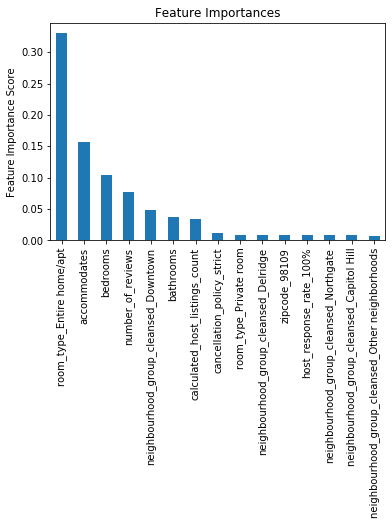

In [306]:
feat_imp = pd.Series(clf.feature_importances_, cleaned_X_train.columns).sort_values(ascending=False).head(15)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

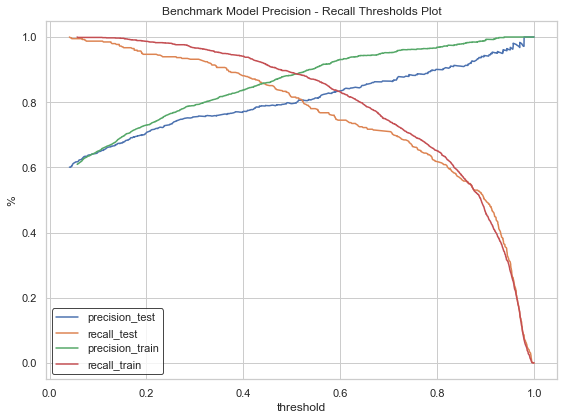

In [307]:
test_labels = y_test
train_labels = y_train
predictions_pos_class = y_pred_proba_test
original_pos_class = y_pred_proba_train
predictions_pos_class

#testing
from sklearn.metrics import precision_recall_curve, roc_curve, auc
precision, recall, thresholds = precision_recall_curve(test_labels, predictions_pos_class)
thresholds = np.append(thresholds, 1) 
precision_train, recall_train, thresholds_train = precision_recall_curve(train_labels, original_pos_class)
thresholds_train = np.append(thresholds_train, 1) 

import seaborn as sns
sns.set(style="whitegrid")

plt.figure(figsize=(8,6))
plt.plot(thresholds, precision, color=sns.color_palette()[0])
plt.plot(thresholds, recall, color=sns.color_palette()[1]) 
plt.plot(thresholds_train, precision_train, color=sns.color_palette()[2])
plt.plot(thresholds_train, recall_train, color=sns.color_palette()[3]) 
leg = plt.legend(('precision_test', 'recall_test', 'precision_train', 'recall_train'), frameon=True) 
leg.get_frame().set_edgecolor('k') 
plt.xlabel('threshold');
plt.ylabel('%');
plt.title('Benchmark Model Precision - Recall Thresholds Plot')
plt.tight_layout()
plt.savefig("Precision and recall vs threshold graph")


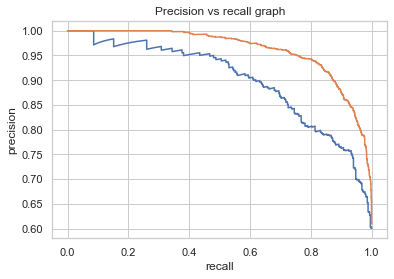

In [308]:
precision, recall, thresholds = precision_recall_curve(test_labels, predictions_pos_class)
plt.plot(recall, precision, color=sns.color_palette()[0]) 
plt.plot(recall_train, precision_train, color=sns.color_palette()[1]) 
leg.get_frame().set_edgecolor('k') 
plt.xlabel('recall') 
plt.ylabel('precision')
plt.title('Precision vs recall graph')
plt.grid(True)
plt.savefig("Precision vs recall graph")


In [310]:
fpr, tpr, thresholds = roc_curve(test_labels, predictions_pos_class)
fpr_train, tpr_train, thresholds_train = roc_curve(train_labels, original_pos_class)

AUC_test = 0.8964 AUC_train = 0.9589


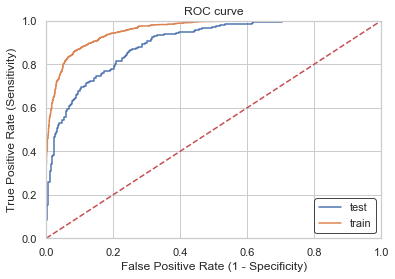

In [311]:
roc_auc = auc(fpr, tpr)
roc_auc_train = auc(fpr_train, tpr_train)
print('AUC_test = %0.4f'% roc_auc, 'AUC_train = %0.4f'% roc_auc_train)
plt.plot(fpr, tpr)
plt.plot(fpr_train, tpr_train)

leg = plt.legend(('test', 'train'), frameon=True) 
leg.get_frame().set_edgecolor('k') 


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0,1],[0,1],'r--')
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.savefig("ROC graph")

##  Evaluate the result 

We analysed a few models and concluded that Gradient Boosting is explaining the dataset the best without too much overfitting overfitting. 
We also used the H20 package to find best parameters for the model.

The prediction model provides us with the following insights:
1. The model of 20 variables: 5 continuous and 15 categorical variables can explain around 52% of the 
    listing price in the testing dataset. 
2. The type of room - entire home/apt is the most important factor in predicting the price.
3. It is followed by number of people the property can accommodate, number of bedrooms. 
number of reviews and whether the property is Downtown.

***
## PART 3: Sentiment analysis of the review dataset.
Our focus will be on analysing the positive and negative reviews and what drives them.
We will also map those reviews to neighbourhoods to find out which areas are most problematic

In [228]:
comments = reviews[['listing_id', 'comments']].copy()
comments.head()

,listing_id,comments
0,7202016,Cute and cozy place. Perfect location to every...
1,7202016,Kelly has a great room in a very central locat...
2,7202016,"Very spacious apartment, and in a great neighb..."
3,7202016,Close to Seattle Center and all it has to offe...
4,7202016,Kelly was a great host and very accommodating ...


In [230]:
def get_neighborhood(listing_id):
    '''
    obtains the neighbourhood from the listings dataset
    '''
    neighbourhood = listings.loc[listings['id'] == listing_id, 'neighbourhood_cleansed'].iloc[0]
    return neighbourhood

get_neighborhood(3946674)


comments['neighbourhood'] = comments['listing_id'].apply(get_neighborhood)
comments.head()

,listing_id,comments,neighbourhood
0,7202016,Cute and cozy place. Perfect location to every...,Lower Queen Anne
1,7202016,Kelly has a great room in a very central locat...,Lower Queen Anne
2,7202016,"Very spacious apartment, and in a great neighb...",Lower Queen Anne
3,7202016,Close to Seattle Center and all it has to offe...,Lower Queen Anne
4,7202016,Kelly was a great host and very accommodating ...,Lower Queen Anne


In [232]:
comments['neighbourhood'].isnull().sum()

0

In [241]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

# SentimentIntensityAnalyzer reference: 
#https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f
#https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/
    
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/vbardarova/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [242]:
analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    '''
    Function to run sentiment intensity analyzer on a sentence and return compound polarity score
    '''
    sentence = str(sentence)
    score = analyser.polarity_scores(sentence)
    return score['compound']


comments['polarity_score'] = comments['comments'].apply(sentiment_analyzer_scores)
comments.head()

,listing_id,comments,neighbourhood,polarity_score
0,7202016,Cute and cozy place. Perfect location to every...,Lower Queen Anne,0.7901
1,7202016,Kelly has a great room in a very central locat...,Lower Queen Anne,0.9872
2,7202016,"Very spacious apartment, and in a great neighb...",Lower Queen Anne,0.8718
3,7202016,Close to Seattle Center and all it has to offe...,Lower Queen Anne,0.8313
4,7202016,Kelly was a great host and very accommodating ...,Lower Queen Anne,0.9783


In [324]:
# Print number of positive, negative and neutral compound polarity scores
print('Number of positive reviews: ',comments['polarity_score'][comments['polarity_score'] > 0].count())
print('Number of negative reviews:  ',comments['polarity_score'][comments['polarity_score'] < 0].count())
print('Number of neutral reviews: ',comments['polarity_score'][comments['polarity_score'] == 0].count())


Number of positive reviews:  82444
Number of negative reviews:   849
Number of neutral reviews:  1556


In [325]:
scores_by_neighbourhood = comments.groupby('neighbourhood')[['polarity_score']].mean().sort_values(by='polarity_score',ascending=False)

In [326]:
scores_by_neighbourhood.describe()

,polarity_score
count,87.000000
mean,0.884000
std,0.027397
min,0.796942
25%,0.873768
50%,0.886114
75%,0.897656
max,0.946186


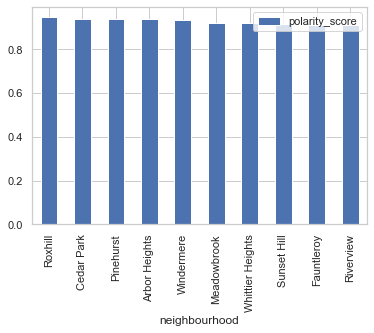

In [327]:
# Visualize top neighborhoods based on reviews
scores_by_neighbourhood.head(10).plot(kind='bar');

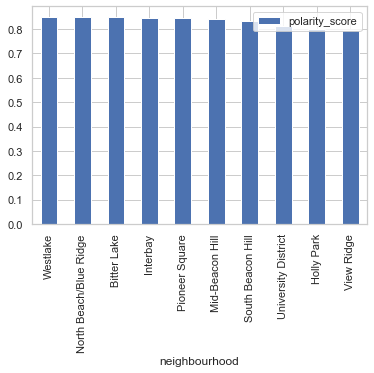

In [328]:
# Visualize bottom 10 neighborhoods based on reviews
scores_by_neighbourhood.tail(10).plot(kind='bar');

#### FINDINGS

Roxhill, Cedar Park and Pinehurst are some of the neighborhoods that have top reviews. 
University District, Holly Park and View Ridge are top by negative reviews.

In [329]:
# Explore the worst reviews
comments.sort_values(by='polarity_score',ascending=False).tail(10)
# comments.sort_values(by='polarity_score',ascending=False).tail(10).to_csv('negative_reviwes.csv')

,listing_id,comments,neighbourhood,polarity_score,host_is_superhost
32787,5805162,Die Ankunft war unkompliziert. Die Lage ist ru...,Ravenna,-0.9881,t
14908,685600,Das Zimmer war wie beschrieben und die Umgebun...,Lawton Park,-0.9885,f
1786,208356,Die Unterkunft ist so wie beschrieben und die ...,International District,-0.9892,f
22483,6115704,Beautiful Condo - Beware : NO AC!\nWe stayed a...,Central Business District,-0.9908,f
18347,26116,Für den Aufenthalt in einer fremdem Stadt hatt...,Broadway,-0.9927,f
75564,1775016,Staying at Robert’s place was a nightmare. At ...,Broadway,-0.9941,f
32404,3291777,Melissa replied to our request and approved bu...,University District,-0.9956,f
84378,4577542,"Die Unterkunft war sehr schön und genau so, wi...",Minor,-0.9961,t
29434,1018204,"leider war esnicht so fein, da die unterkunft ...",Minor,-0.9970,f
50261,258571,Wir sind 5 Nächte geblieben. Und es ist eine A...,Broadway,-0.9975,f


In [ ]:
#### FINDINGS
Most of the negative ones are in a foreign language which is something we will have to do as a pre-processing step - 
identify the language and only evaluate english reviews.

The negative reviews which are in english mention the gursts complaining about the lack of A/C and fans, 
host being rude, construction noise ruining people's stay, poor condition of the place etc.

In [ ]:
def get_host(listing_id):
    '''
    obtains info whether the host is superhost from the listings dataset
    '''
    host_is_superhost = listings.loc[listings['id'] == listing_id, 'host_is_superhost'].iloc[0]
    return host_is_superhost

get_host(3946674)


comments['host_is_superhost'] = comments['listing_id'].apply(get_host)

In [263]:
comments['polarity_score'][comments['host_is_superhost']=='f'].describe()

count    52362.000000
mean         0.866544
std          0.245148
min         -0.997500
25%          0.882325
50%          0.947600
75%          0.974700
max          0.999700
Name: polarity_score, dtype: float64

In [262]:
comments['polarity_score'][comments['host_is_superhost']=='t'].describe()

count    32487.000000
mean         0.914217
std          0.173296
min         -0.996100
25%          0.920700
50%          0.962200
75%          0.980800
max          0.999500
Name: polarity_score, dtype: float64

In [330]:
import seaborn as sns
from scipy import stats

stats.ttest_ind(comments['polarity_score'][comments['host_is_superhost']=='f'],comments['polarity_score'][comments['host_is_superhost']=='t'], equal_var = False)
# t-test displaying p-value less than 0.05, hence the null hypothesis cannot be rejected,meaning that the two scores
# could be significantly different 

Ttest_indResult(statistic=-33.11786532125864, pvalue=5.896048058164979e-239)

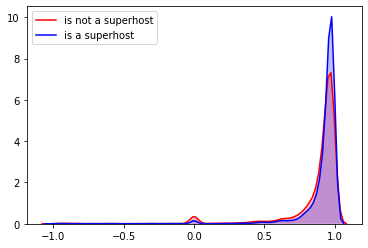

In [266]:
# a plot describing both hosts and superhosts reviews scores and displaying no material difference between them

p1=sns.kdeplot(comments['polarity_score'][comments['host_is_superhost']=='f'], shade=True, color="r", label = 'is not a superhost')
p1=sns.kdeplot(comments['polarity_score'][comments['host_is_superhost']=='t'], shade=True, color="b", label = 'is a superhost')
#sns.plt.show()